Première cellule : Fonctions de la synthèse précédente. Presque toutes inchangées. Elle est simplement là pour être exécutée.

In [2]:
import numpy as np
from random import *


class Layer_Dense:

    #Initialisation d'une couche de réseau
    def __init__(self, d_inputs, n_neurons, n_inputs):
        self.d_inputs = d_inputs
        self.n_neurons = n_neurons
        self.n_inputs = n_inputs
        self.weights = np.empty((n_neurons, d_inputs))
        self.biases = np.empty((n_neurons, n_inputs))

    #Utilisation d'une couche
    def forward(self, inputs):
        self.output= np.dot(self.weights, inputs) + self.biases

    #Attribution aléatoire de paramètres, globalement pour initialiser un réseau si on ne dispose pas déjà d'un modèle
    def attrib_r(self, fact=1):
      self.weights = 0.10 * np.random.randn(self.n_neurons, self.d_inputs)* fact
      self.biases = np.tile(0.1*fact * np.random.randn(1, self.n_neurons).reshape(-1, 1), (1, self.n_inputs))

    #Création d'une couche subissant des mutations aléatoires à partir d'une couche "modèle", fonction utilisée pour les apprentissages "heuristiques"
    # p : probabilité qu'un coefficient soit muté. cr : intervalle dans lequel est choisie la variation des paramètres mutés
    def mut(self, p, cr):

        Lay = Layer_Dense(self.d_inputs, self.n_neurons, self.n_inputs)

        Lay.weights = self.weights.copy()
        Lay.biases = self.biases.copy()

        n_weights = self.n_neurons*self.d_inputs
        num_w_mod = int(n_weights * p)

        if num_w_mod > 0:
            indices = np.unravel_index(np.random.choice(n_weights, num_w_mod, replace=False), (self.n_neurons, self.d_inputs))
            changes_w = np.random.uniform(-cr, cr, num_w_mod)
            Lay.weights[indices] += changes_w

        n_b = self.n_neurons
        num_b_mod = int(n_b*p)+ (1 if random() < 0.5 else 0)

        if num_b_mod > 0:
            indices_b = np.unravel_index(np.random.choice(n_b, num_b_mod, replace=False), (n_b, 1))
            changes_b = np.random.uniform(-cr, cr, num_b_mod)
            Lay.biases[indices_b] += changes_b
        
        return(Lay)
    
class NeuralN:
    #Initialisation d'un réseau, constitué d'une liste de couches
    def  __init__(self, l):
        self.l = l
        self.wl = []

    #Obtenir le résultat donné par le réseau à partir d'une entrée
    def process(self, input):
        output = input
        for layers in self.l:
            layers.forward(output)
            output = layers.output
        return output.T
    
    #Mutation aléatoire du réseau
    def mutNN(self, p, cr):
        return NeuralN([layers.mut(p, cr) for layers in self.l])
    
    #Attribution aléatoire des paramètres du réseau
    def attribNN_r(self, fact=1):
        for layers in self.l:
            layers.attrib_r(fact)
        
    #Pour manipuler plus facilement les poids
    def wl_update(self):
        self.wl= []
        for r in self.l:
            n , d = r.n_neurons, r.d_inputs
            for i in range(n):
                for k in range(d): #weights
                    self.wl.append(r.weights[i][k])
            for i in range(n): #biases
                self.wl.append(r.biases[i][0])

    def save_to_file(self, filename, network_id):
        # Étape 1 : Lire le contenu existant du fichier pour vérifier les réseaux déjà présents
        try:
            with open(filename, 'r') as f:
                lines = f.readlines()
        except FileNotFoundError:
            lines = []  # Si le fichier n'existe pas, on travaille avec une liste vide

        # Étape 2 : Filtrer les lignes pour enlever les blocs de l'ancien réseau s'il existe
        new_lines = []
        skip = False  # Indicateur pour ignorer le bloc actuel (réseau avec le même ID)

        for line in lines:
            if line.strip() == f'### Network ID: {network_id} ###':
                skip = True  # Début du bloc à ignorer
            elif line.strip() == "### End of Network ###" and skip:
                skip = False  # Fin du bloc à ignorer
            elif not skip:
                new_lines.append(line)  # Copier uniquement les lignes qui ne sont pas dans le bloc à ignorer

        # Étape 3 : Ajouter le nouveau réseau à `new_lines`
        new_lines.append(f'### Network ID: {network_id} ###\n')
        for layer in self.l:
            new_lines.append(f'{layer.d_inputs},{layer.n_neurons},{layer.n_inputs}\n')
            
            # Ajouter les poids
            new_lines.append('weights:\n')
            for row in layer.weights:
                new_lines.append(','.join(map(str, row)) + '\n')

            # Ajouter les biais
            new_lines.append('biases:\n')
            for row in layer.biases:
                new_lines.append(','.join(map(str, row)) + '\n')
        
        new_lines.append("### End of Network ###\n")

        # Étape 4 : Écrire les lignes mises à jour dans le fichier
        with open(filename, 'w') as f:  # Mode écriture pour écraser l'ancien contenu
            f.writelines(new_lines)

    # Recréer un réseau sauvegardé avec un identifiant donné
    def load_from_file(self, filename, network_id):
        self.l = []  # Réinitialiser les couches avant de charger
        with open(filename, 'r') as f:
            lines = f.readlines()
            i = 0
            found = False  # Pour détecter si le réseau a été trouvé

            while i < len(lines):
                # Rechercher le début du réseau avec l'ID donné
                if lines[i].strip() == f'### Network ID: {network_id} ###':
                    found = True
                    i += 1
                    while i < len(lines) and lines[i].strip() != "### End of Network ###":
                        # Charger les dimensions de la couche
                        d_inputs, n_neurons, n_inputs = map(int, lines[i].strip().split(','))
                        i += 1

                        layer = Layer_Dense(d_inputs, n_neurons, n_inputs)

                        # Charger les poids
                        if lines[i].strip() == 'weights:':
                            i += 1
                            weights = []
                            for _ in range(n_neurons):
                                weights.append(list(map(float, lines[i].strip().split(','))))
                                i += 1
                            layer.weights = np.array(weights)

                        # Charger les biais
                        if lines[i].strip() == 'biases:':
                            i += 1
                            biases = []
                            for _ in range(n_neurons):
                                biases.append(list(map(float, lines[i].strip().split(','))))
                                i += 1
                            layer.biases = np.array(biases)

                        # Ajouter la couche chargée à la liste des couches du réseau
                        self.l.append(layer)
                
                if found and lines[i].strip() == "### End of Network ###":
                    break  # Fin de chargement du réseau
                i += 1

            if not found:
                print(f"Network ID '{network_id}' not found.")
    
class Opti:

    #Les "Opti" sont un quadruplet regroupant un algorithme d'optimisation, un réseau à entrainer, ainsi que la fonction de perte et son gradient, sur lesquels on souhaite entrainer le réseau
    #Il est intéressant de créer cette structure en plus de celle des "Algos" (à venir) qui est elle orientée sur l'aspect purement théorique / algorithmique. Les "Opti" sont une application pratique des "Algos".
    def __init__(self, fonc, NN, grad, loss):
        self.f = fonc
        self.NN = NN
        self.grad = grad
        self.gl = []
        self.loss = loss
        t = 0
        for r in NN.l:
            t += (r.n_neurons*(r.d_inputs+1))
        self.v = (np.zeros((t, fonc.vl)) if self.f.vlist == [] else [self.f.vlist for i in range(t)])

    
    def gr_update(self):
        self.gl = self.grad(self.NN.wl)

    #Modification des poids du réseau tel que l'algorithme d'optimisation l'indique.
    def update(self):
        self.gr_update()
        j = 0
        for r in self.NN.l:
            n , d = r.n_neurons, r.d_inputs
            for i in range(n):
                for k in range(d): #weights
                    (r.weights[i][k], self.v[(i*d)+k+j]) = self.f.mod(r.weights[i][k], self.gl[(i*d)+k+j], self.v[(i*d)+k+j])
            j+=n*d
            for i in range(n): #biases
                (r.biases[i], self.v[i+j]) = self.f.mod(r.biases[i][0], self.gl[i+j], self.v[i+j])
            j += n

    #Processus de modification des poids de nombreuses fois à la suite
    #train renvoie l'évolution de la perte et des poids, train2 renvoie uniquement la perte
    def train(self, nb_epoch):
        losslst, poidslst = [], []
        for epoch in range(nb_epoch):
            self.NN.wl_update()
            losslst.append(self.loss(self.NN.wl))
            poidslst.append(self.NN.wl)
            self.update()
        return (losslst, poidslst)
    
    def train2(self, nb_epoch):
        losslst = []
        for epoch in range(nb_epoch):
            self.NN.wl_update()
            losslst.append(self.loss(self.NN.wl))
            self.update()
        return losslst



class Algos:
    #Un algorithme d'optimisation "Algo" est constitué d'un algorithme nécessitant une liste d'hyperparamètres ainsi que de variables pour fonctionner, d'où la nature de la structure.
    def __init__(self, algo, param, vlen, name="", vlist=[]):
        self.a = algo
        self.p = param
        self.vl = vlen
        self.name = name
        self.vlist = vlist

    def mod(self, w, g, vlst):
        return self.a(w, g, self.p, vlst)
    
from matplotlib import pyplot as p

class Visu:
    #Objet utilisant les classes précédentes pour, à partir d'une liste d'"Algos" et d'un format de réseau, effectuer tout le processus d'entraînement puis afficher les résulats.
    def __init__(self, NNi, fctgr, perte, l_algos, n, start):
        self.l_algos = l_algos
        self.n = n
        if start == []:
            NNi.attribNN_r()
        else:
            j = 0
            for r in NNi.l:
                n,d = r.n_neurons, r.d_inputs
                for i in range(n):
                    for k in range(d): #weights
                        r.weights[i][k] = start[(i*d)+k+j]
                j+=n*d
                for i in range(n): #biases
                    r.biases[i] = start[i+j]
                j+=n

        self.NNi = NNi
        self.fct = fctgr
        self.perte = perte

    #Affiche les résultats via une courbe 2d, évolution de la perte en fonction du nombre d'itérations.
    def plt(self, logscale=True, return_weights=False):
        p.figure(figsize=(17,7))
        colors = ['b', 'c', 'm', 'g', 'y', 'r']
        if return_weights:
            for i, algos in enumerate(self.l_algos):
                opt = Opti(algos, self.NNi.mutNN(0,0), self.fct, self.perte)
                res = opt.train(self.n)
                p.plot([a for a in range(self.n)], res[0], (colors[i] if i < 7 else 'k'), label=algos.name)
                print(res[1])
        else:
            for i, algos in enumerate(self.l_algos):
                opt = Opti(algos, self.NNi.mutNN(0,0), self.fct, self.perte)
                p.plot([a for a in range(self.n)], opt.train2(self.n), (colors[i] if i < 7 else 'k'), label=algos.name)
        p.legend(loc='upper right')
                
        if logscale:
            p.yscale('log')

    #Ouvre une interface 3d permettant de visualiser l'évolution des poids sur une fonction de perte à 2 entrées x,y.
    #Utile pour comprendre le comportement des algorithmes d'optimisation et développer des solutions.
    def visu(self, coosx, coosy, dt, ballscale=0.5, logscale=False):#Pour de la dimension 2
        from mayavi import mlab
        import time as t
        coos, losses, balls = [], [], []
        c = [(0.1, 0.6, 1), (1, 0.6, 0.1), (0.3, 0.6, 0.3), (1, 1, 1)]
        x = np.linspace(coosx[0],coosx[1], 200)
        y = np.linspace(coosy[0],coosy[1], 200)
        X1, Y1 = np.meshgrid(x, y)
        Z1 = (self.perte([X1, Y1]) if not logscale else np.log(self.perte([X1, Y1])))
        mlab.figure(size=(800, 600), bgcolor=(0.4, 0.4, 0.6))
        mlab.mesh(X1, Y1, Z1, colormap='CMRmap')
        for i, algos in enumerate(self.l_algos):
            o = Opti(algos, self.NNi.mutNN(0,0), self.fct, self.perte)
            res = o.train(self.n)
            coos.append(res[1])
            losses.append((np.log(res[0]) if logscale else res[0]))
            balls.append(mlab.points3d(coos[i][0][0], coos[i][0][1], losses[i][0], scale_factor=ballscale, color=c[i]))

        def update_ball():
            i = 0
            while i < self.n-1:
                for a in range(len(balls)):
                    co = coos[a][i]
                    balls[a].mlab_source.set(x=co[0], y=co[1], z=losses[a][i])
                t.sleep(dt)    
                yield
                i+=1

        anim = update_ball()
        mlab.show(stop=True)

        while True:
            try:
                next(anim)
            except StopIteration:
                break
            mlab.process_ui_events()
        mlab.show()
        
path2 = "save_NNs2.txt"

def Sgd(w, g, p, vl):
    return (w - p[0]*g, vl)

def SgdM1(w, g, p, vl):
    momentum, lr, B = vl[0], p[0], p[1]
    momentum = (1-B)*momentum + B*g
    return (w-lr*momentum, [momentum])

def SgdM2(w, g, p, vl):
    momentum, lr= vl[0], p[0]
    momentum += g
    return (w-lr*momentum, [momentum])

def SgdM3(w, g, p, vl):
    momentum, lr, B = vl[0], p[0], p[1]
    momentum = (1-B)*momentum + g
    return (w-lr*momentum, [momentum])

SGD_Trad = Algos(Sgd, [0.03], 0, name="SGD_Trad")

SGDM_Trad = Algos(SgdM1, [0.03, 0.8], 1,name="SGDM_Trad")
SGDM2 = Algos(SgdM2, [0.05], 1)
SGDM3 = Algos(SgdM3, [0.06, 0.8], 1)
SGD_Slow = Algos(Sgd, [0.001], 0, name="SDG_Slow")
SGDM_Slow= Algos(SgdM3, [0.003 , 0.04], 1, name="SGDM_Slow")

def Adam(w, g, p, vl):
    lr, b1, b2, eps = p[0], p[1], p[2], p[3]
    m1, m2, v, v2 = vl[1], vl[2], vl[3], vl[4]
    m1 = b1*m1 +(1-b1)*g
    m2 = m1/(1-b1**(vl[0]+1))
    v = b2*v+(1-b2)*(g**2)
    v2 = v/(1-b2**(vl[0]+1))
    return (w - lr*m2*(1/(eps+np.sqrt(v2))), [vl[0]+1, m1, m2, v, v2])

ADAM_Trad = Algos(Adam, [0.03, 0.9, 0.999, 10**(-8)], 5, name="Adam_Trad")

import math as m
def rosenbrock(lst):
    x, y = lst[0], lst[1]
    return((1-x)**2 + 100*(y-(x)**2)**2)
def grosenbrock(lst):
    x, y = lst[0], lst[1]
    return [2*(x-1) +400*x*((x)**2 -y), 200*(y-(x)**2)]

def rastrigin(lst):
    return (10*len(lst) + np.sum([(lst[i]**2 - 10*np.cos(2*m.pi*lst[i])) for i in range(len(lst))], axis = 0))
def grastrigin(lst):
    return [(2*lst[i]+ 20*m.pi*np.sin(2*m.pi*lst[i])) for i in range(len(lst))]

def himmelblau(lst):
    x, y = lst[0], lst[1]
    return ((x**2 +y-11)**2 + (x+ y**2 - 7)**2)
def grhimmelblau(lst):
    x, y = lst[0], lst[1]
    return [4*x*(x**2 + y -11) + 2*(x+ y**2 - 7), 2*(x**2 + y -11)+4*y*(x+ y**2 -7)]

def three_hump(lst):
    x, y = lst[0], lst[1]
    return(2*(x**2)-1.05*(x**4)+(x**6)/6 +x*y + y**2)
def gthree_hump(lst):
    x, y = lst[0], lst[1]
    return [4*x-4.2*(x**3)+x**5+y, 2*y]

import math as m
import statistics as s

def softmax_abs(lst):
    l1 = list(map(abs, lst))
    somme = sum(l1)
    l2 = [l/(somme + (10**(-20))) for l in l1]
    l = list(map(m.exp, l2))
    s = sum(l)
    return [((10**(-9))+(l[i]/s))*(1 if lst[i] > 0 else -1) for i in range(len(lst))]

def softmax_abs2(lst):
    l1 = list(map(abs, lst))
    somme = sum(l1)
    l2 = [l/(somme + (10**(-20))) for l in l1]
    l = list(map(m.exp, l2))
    s = sum(l)
    return [((10**(-9))+(l[i]/s))*(1 if lst[i] > 0 else -1) for i in range(len(lst))], somme


def o1_a(w, g, p, vl):
    gl, NN, iter = vl[1], vl[2], vl[3]
    gl.pop(0)
    gl.append(g)
    if iter == 0:
        gl = [g]*5
    alpha = abs(NN.process(np.array([softmax_abs(gl)]).T)[0][0])

    b, mom = p[0], vl[0]
    mom = (1-b)*mom +b*g
    return(w-alpha*mom, [mom, gl, NN, iter+1])

def o1_2_a(w, g, p, vl):
    gl, NN, iter = vl[1], vl[2], vl[3]
    gl.pop(0)
    gl.append(g)
    if iter == 0:
        gl = [g]*5

    softmax, somme = softmax_abs2(gl)
    v  = s.variance(gl)/somme
    softmax.append(v)
    
    out = abs(NN.process(np.array([softmax]).T)[0][0])
    alpha = m.exp(-out*100)
    b, mom = p[0], vl[0]
    mom = (1-b)*mom +b*g
    return(w-alpha*mom, [mom, gl, NN, iter+1])

def o1_3_a(w, g, p, vl):
    gl, NN, iter = vl[1], vl[2], vl[3]
    gl.pop(0)
    gl.append(g)
    if iter == 0:
        gl = [0]*4+[g]

    softmax, somme = softmax_abs2(gl)
    v  = np.var(gl)/somme
    softmax.append(v)
    
    out = abs(NN.process(np.array([softmax]).T)[0][0])
    alpha = m.exp(-out*100)
    b, mom = p[0], vl[0]
    mom = (1-b)*mom +b*g
    return(w-alpha*mom, [mom, gl, NN, iter+1])

Boucle d'entraînement fortement revue. C'est le résultat des fichiers Codes4 et Codes5 que je ne metterai pas sur le Github car ce serait inutile.
Les améliorations proviennent majoritairement d'un point de vue optimisation. J'ai dans Codes5 mesuré les temps d'éxecutions des différents éléments de chacune des fonctions principales de l'entraînement. Obtenir une variance était l'élément le plus couteux en temps, à ma grande surprise. J'ai utilisé la variance numpy plutôt que statistics, ce qui a divisé par 3 le temps de cette tâche. J'ai essayé d'utiliser numba pour améliorer les performances des produits matriciels et autres tâches, cependant les résultats n'était pas concluants.

D'un point de vue algorithmique, j'ai implémenté "une descente de gradient" dans le cadre de l'apprentissage non supervisé en incitant le réseaux à continuer à progresser dans une direction qui a marché à l'itération précédente, si jamais la précédente a créé une amélioration. Dans ce cas, je consacre 1/3 des agents à cette tâche.

J'ai implémenté une pre-termination des agents au fil de l'évaluation. Puisque les mutations donnent lieux à des agents particulièrement indésirables, je réduis l'effectif de moitié à 2 reprises durant une étape de l'entraînement : Explanation : Une étape (génération) consiste en nb_iter_par_gen épreuves. Je réduis l'effectif des Agents en prenant ceux dont la perte est inférieure à la perte médiane, à iter = nb_iter/4 et iter = nb_iter/2.

J'ai mis de l'aléatoire dans le nombre d'itérations de l'optimizer sur le réseau sous jacent qu'il entraine (à ne pas confondre avec nb_iter_par_gen qui est le nombre d'épreuves par génération), afin d'éviter une adaptation à un cas trop précis, qui était exactement la raison pour laquelle on observait sur certains graphiques de grandes spikes sur la perte après plusieurs centaines d'itérations.

Pour que les pre-termination ne sélectionnent pas trop arbitrairement, l'ordre des épreuves change aléatoirement à chaque génération (cf la fonction permutation)

J'ai mis l'affichage de quelques stats supplémentaires

J'ai catch les exceptions et j'ai mis les paths en relatif. Normalement. Vous devriez pouvoir tout run. Je vais update saves_NN2.txt sur le Git

C:\Users\paulm\AppData\Local\Temp\ipykernel_9252\1115851160.py:367: RuntimeWarning: overflow encountered in scalar power
  return((1-x)**2 + 100*(y-(x)**2)**2)
C:\Users\paulm\AppData\Local\Temp\ipykernel_9252\1115851160.py:370: RuntimeWarning: overflow encountered in scalar multiply
  return [2*(x-1) +400*x*((x)**2 -y), 200*(y-(x)**2)]
C:\Users\paulm\AppData\Local\Temp\ipykernel_9252\1115851160.py:405: RuntimeWarning: invalid value encountered in scalar divide
  l2 = [l/(somme + (10**(-20))) for l in l1]
C:\Users\paulm\AppData\Local\Temp\ipykernel_9252\1115851160.py:367: RuntimeWarning: overflow encountered in scalar multiply
  return((1-x)**2 + 100*(y-(x)**2)**2)
C:\Users\paulm\AppData\Local\Temp\ipykernel_9252\1115851160.py:379: RuntimeWarning: overflow encountered in scalar power
  return ((x**2 +y-11)**2 + (x+ y**2 - 7)**2)
C:\Users\paulm\AppData\Local\Temp\ipykernel_9252\1115851160.py:382: RuntimeWarning: overflow encountered in scalar multiply
  return [4*x*(x**2 + y -11) + 2*(x+

Training time : 10.100263118743896 seconds.
Génération 0 done, bestloss = 1000000000, log_10 :9.0, l'Agent provenait-il de la descente: Pas utilisé
Agent mutation time : 0.01770949363708496 seconds.
Training time : 11.238025188446045 seconds.
Génération 1 done, bestloss = 3182082.0765982354, log_10 :6.5027, l'Agent provenait-il de la descente: Pas utilisé
Agent mutation time : 0.014251232147216797 seconds.
Training time : 17.421463012695312 seconds.
Génération 2 done, bestloss = 3127164.964138479, log_10 :6.4952, l'Agent provenait-il de la descente: Non
Agent mutation time : 0.005007266998291016 seconds.
Training time : 6.503871440887451 seconds.
Génération 3 done, bestloss = 3112960.659674195, log_10 :6.4932, l'Agent provenait-il de la descente: Pas utilisé
Agent mutation time : 0.0 seconds.
Training time : 17.219499349594116 seconds.
Génération 4 done, bestloss = 3150524.5721985633, log_10 :6.4984, l'Agent provenait-il de la descente: Pas utilisé
Agent mutation time : 0.0112922191619

c:\Users\paulm\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\paulm\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training time : 11.151295900344849 seconds.
Génération 13 done, bestloss = 1000000000, log_10 :9.0, l'Agent provenait-il de la descente: Pas utilisé
Agent mutation time : 0.0 seconds.
Training time : 8.326503276824951 seconds.
Génération 14 done, bestloss = 2272605.5469017862, log_10 :6.3565, l'Agent provenait-il de la descente: Pas utilisé
Agent mutation time : 0.015622615814208984 seconds.
Training time : 5.828608274459839 seconds.
Génération 15 done, bestloss = 1000000000, log_10 :9.0, l'Agent provenait-il de la descente: Pas utilisé
Agent mutation time : 0.020473718643188477 seconds.
Training time : 14.212254762649536 seconds.
Génération 16 done, bestloss = 2268418.3969141133, log_10 :6.3557, l'Agent provenait-il de la descente: Pas utilisé
Agent mutation time : 0.005648374557495117 seconds.
Training time : 13.279486894607544 seconds.
Génération 17 done, bestloss = 2269770.438053791, log_10 :6.356, l'Agent provenait-il de la descente: Pas utilisé
Agent mutation time : 0.00906515121

C:\Users\paulm\AppData\Local\Temp\ipykernel_9252\2988573927.py:30: RuntimeWarning: overflow encountered in scalar multiply
  self.loss += r[len(r)-1]*(10**5)


Training time : 17.65149474143982 seconds.
Génération 28 done, bestloss = 2428047.9395334297, log_10 :6.3853, l'Agent provenait-il de la descente: Pas utilisé
Agent mutation time : 0.019303321838378906 seconds.
Training time : 16.200112342834473 seconds.
Génération 29 done, bestloss = 2440159.535092075, log_10 :6.3874, l'Agent provenait-il de la descente: Pas utilisé
Agent mutation time : 0.0 seconds.
Training time : 8.06248688697815 seconds.
Génération 30 done, bestloss = 2442847.570135994, log_10 :6.3879, l'Agent provenait-il de la descente: Pas utilisé
Agent mutation time : 0.0 seconds.
Training time : 12.936842441558838 seconds.
Génération 31 done, bestloss = 2403945.1928470046, log_10 :6.3809, l'Agent provenait-il de la descente: Non
Agent mutation time : 0.015019655227661133 seconds.
Training time : 6.610884428024292 seconds.
Génération 32 done, bestloss = 2410412.6498995083, log_10 :6.3821, l'Agent provenait-il de la descente: Pas utilisé
Agent mutation time : 0.0 seconds.
Train

C:\Users\paulm\AppData\Local\Temp\ipykernel_9252\1115851160.py:386: RuntimeWarning: overflow encountered in scalar power
  return(2*(x**2)-1.05*(x**4)+(x**6)/6 +x*y + y**2)
C:\Users\paulm\AppData\Local\Temp\ipykernel_9252\1115851160.py:386: RuntimeWarning: invalid value encountered in scalar add
  return(2*(x**2)-1.05*(x**4)+(x**6)/6 +x*y + y**2)
C:\Users\paulm\AppData\Local\Temp\ipykernel_9252\1115851160.py:389: RuntimeWarning: overflow encountered in scalar power
  return [4*x-4.2*(x**3)+x**5+y, 2*y]
C:\Users\paulm\AppData\Local\Temp\ipykernel_9252\1115851160.py:389: RuntimeWarning: invalid value encountered in scalar add
  return [4*x-4.2*(x**3)+x**5+y, 2*y]


Training time : 12.572536945343018 seconds.
Génération 44 done, bestloss = 3315609.6446394958, log_10 :6.5206, l'Agent provenait-il de la descente: Pas utilisé
Agent mutation time : 0.0 seconds.
Training time : 13.555079221725464 seconds.
Génération 45 done, bestloss = 3264761.179020509, log_10 :6.5139, l'Agent provenait-il de la descente: Pas utilisé
Agent mutation time : 0.0 seconds.
Training time : 9.008204698562622 seconds.
Génération 46 done, bestloss = 1000000000, log_10 :9.0, l'Agent provenait-il de la descente: Pas utilisé
Agent mutation time : 0.0 seconds.
Training time : 7.8765459060668945 seconds.
Génération 47 done, bestloss = 3309498.531376944, log_10 :6.5198, l'Agent provenait-il de la descente: Pas utilisé
Agent mutation time : 0.0 seconds.
Training time : 8.00981330871582 seconds.
Génération 48 done, bestloss = 3330427.082025415, log_10 :6.5225, l'Agent provenait-il de la descente: Pas utilisé
Agent mutation time : 0.0 seconds.
Training time : 11.817636013031006 seconds

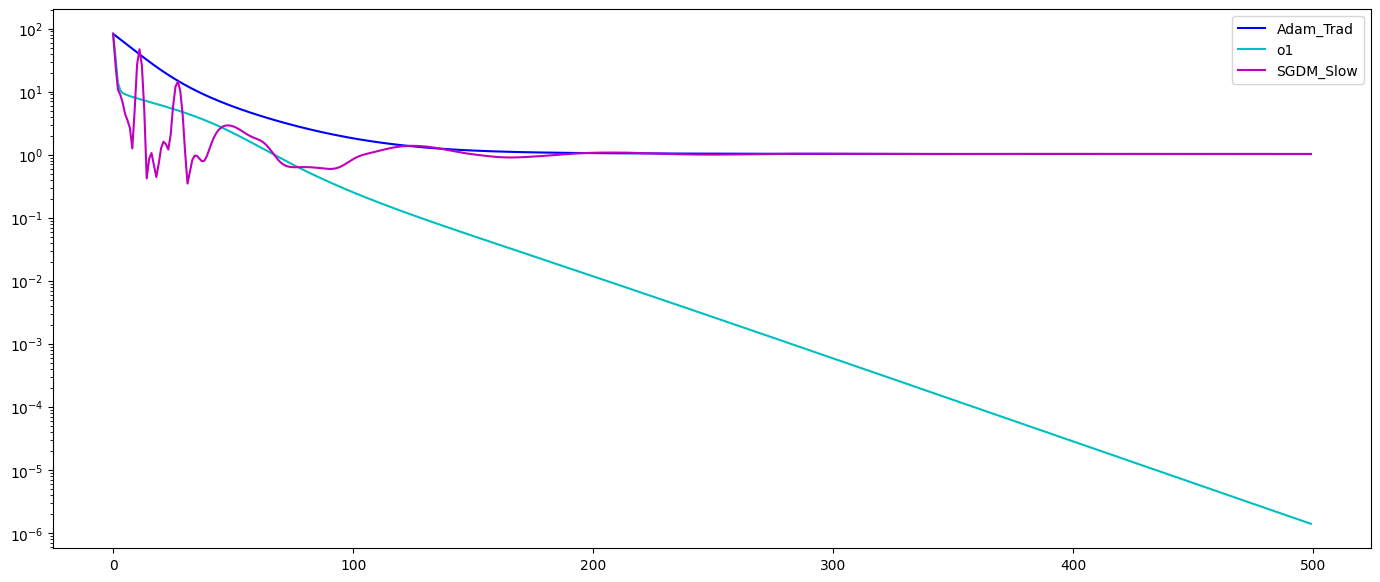

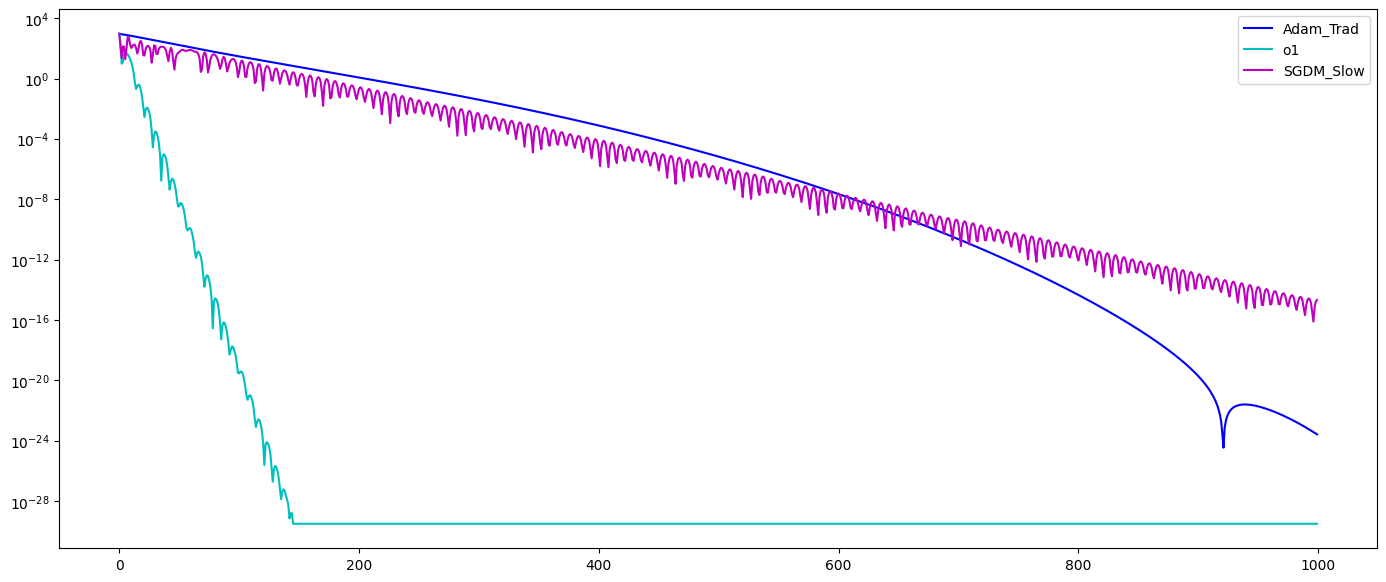

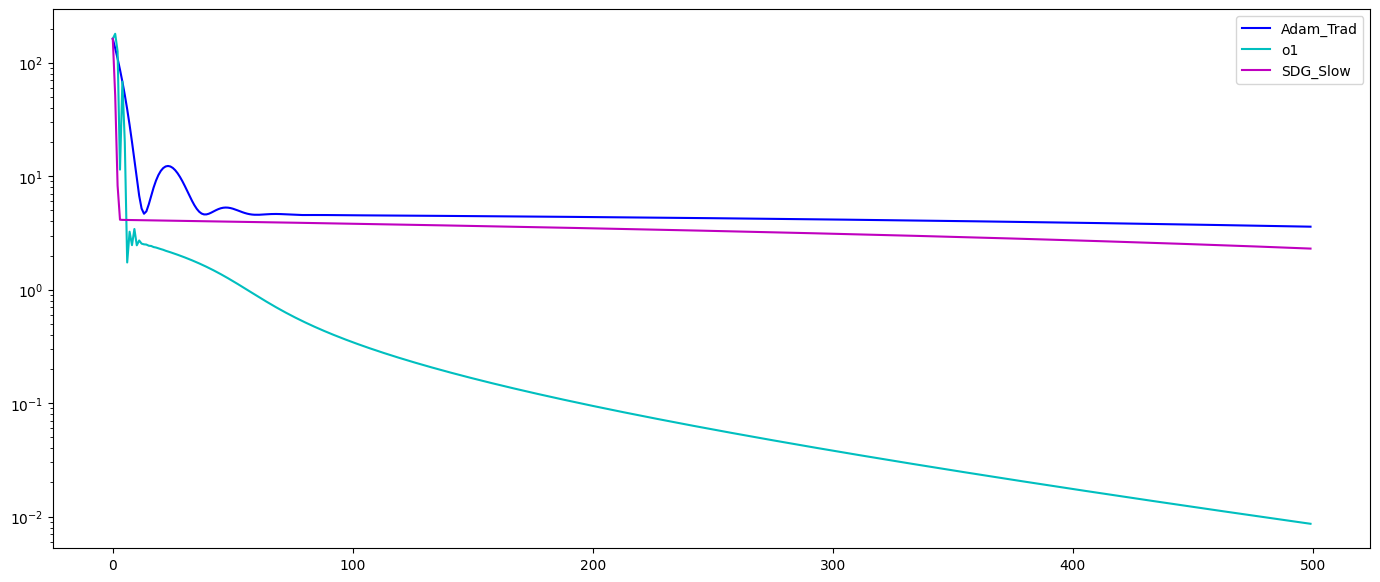

In [61]:
#Compet des o1. Algos génétiques
import time as t
o1NN = NeuralN([Layer_Dense(6, 4, 1), Layer_Dense(4, 3, 1), Layer_Dense(3, 1, 1)])
hyperparam = 0.6
#o1NN.load_from_file(path2, "o1_3_best")
o1NN.load_from_file(path2, "model1")

NNinit = o1NN
class o1Agent:
    def __init__(self, NN):
        self.NN = NN.mutNN(0.3, 0.04)
        self.loss = 0
        self.state = True

    def evaluate(self, NNtest):
        if self.state:
            o1 = Algos(o1_3_a, [hyperparam], 4, name="o1", vlist=[0,[0,0,0,0,0], self.NN, 0])

            opt1 = Opti(o1, NNtest.mutNN(0,0), gthree_hump, three_hump)
            try:
                r = opt1.train2(100+int(random()*100))
                self.loss += r[len(r)-1]*(10**5)
            except ValueError or ZeroDivisionError or RuntimeWarning:
                self.state = False


            opt2 = Opti(o1, NNtest.mutNN(0,0), grhimmelblau, himmelblau)
            try:
                r = opt2.train2(30)
                self.loss += r[len(r)-1]*(10**5)
            except ValueError or ZeroDivisionError or RuntimeWarning:
                self.state = False
            

            opt3 = Opti(o1, NNtest.mutNN(0,0), grosenbrock, rosenbrock)
            try:
                r = opt3.train2(100+int(random()*100))
                self.loss += r[len(r)-1]
            except ValueError or ZeroDivisionError or RuntimeWarning:
                self.state = False
            if m.isnan(self.loss):
                self.state = False

    def mutate(self, bestAgent, p, cr):
        self.loss = 0
        self.state = True
        self.NN = bestAgent.NN.mutNN(p, cr)

    def mutate_descente(self, bestAgent, diff, p, cr, b):
        self.loss = 0
        self.state = True
        self.NN = bestAgent.NN.mutNN(p, cr)
        for i, r in enumerate(self.NN.l):
            r.weights = r.weights + b*diff[i][0]
            r.biases = r.biases + b*diff[i][1]

def permutation(n):
    #Retourne une permutation aléatoire de [0, n-1]
    lst = list(range(n))
    shuffle(lst)
    return lst

#Paramètres de l'entrainement à twister vous même si jamais
nb_generations = 50
pop = 30 #Nb Agents qui entrainent des réseaux
nb_iter_par_gen = 50 #Nombre d'épreuves (points de départ de procédés d'entrainements différents) sur chaque map 
beta = 0.5 #Learning rate dans la pseudo descente de gradient sur certains Agents
prob = 0.2 #Proportion des weights/biases changés lors des mutations

Agents = []
Results = []
prevbestNN, previndbest, indBest = NNinit, 0, 0

flag_descente_init = False

for i in range(pop):
    Agents.append(o1Agent(NNinit))
Agents[0].NN = NNinit.mutNN(0,0)

lNNt = [NeuralN([Layer_Dense(1,1,1)]) for a in range(nb_iter_par_gen)]

for NNt in lNNt:
    NNt.attribNN_r(fact=9)

lNNt[0].l[0].weights[0][0] = -1.5
lNNt[0].l[0].biases[0] = 2.5

for e in range(nb_generations):

    sigma = permutation(nb_iter_par_gen)
    t_0 = t.time()
    for iter in range(nb_iter_par_gen):
        
        #Pre-termination
        if iter >2 and (iter == int(nb_iter_par_gen/4) or iter == int(nb_iter_par_gen/2)):
            lossesprov =[]
            for i, ag in enumerate(Agents):
                if ag.state:
                    lossesprov.append((ag.loss, i))
            med = np.median([l[0] for l in lossesprov])
            for c in lossesprov:
                if c[0] > med :
                    Agents[c[1]].state = False



        for ag in Agents:
            ag.evaluate(lNNt[sigma[iter]])
    print("Training time : "+str(t.time()-t_0)+" seconds.")

    t_0 = t.time()
    previndbest, bestLoss = indBest, 10**9
    for i, ag in enumerate(Agents):
        if ag.loss < bestLoss and ag.state:
            bestLoss, indBest = ag.loss, i
    Results.append(bestLoss)
    
    print('Génération '+str(e)+' done, bestloss = '+str(round(bestLoss, 10))+", log_10 :"+str((round(m.log(bestLoss, 10), 4)))+", l'Agent provenait-il de la descente: "+("Pas utilisé" if not flag_descente_init else ("Oui" if (indBest <= int(pop/3) and (indBest != previndbest)) else "Non")))

    #Obtention de la diff + mutation
    if indBest == previndbest:
        flag_descente_init = False
        for i in range(pop):
            if i != indBest:
                Agents[i].mutate(Agents[indBest], prob, 0.01*((bestLoss)**(1/9)))
        Agents[indBest].loss = 0
        Agents[indBest].state = True
    else:
        flag_descente_init = True
        diff = []
        for i in range(len(prevbestNN.l)):
            diff.append((Agents[indBest].NN.l[i].weights-prevbestNN.l[i].weights, Agents[indBest].NN.l[i].biases-prevbestNN.l[i].biases))

        for i in range(pop):
            if i != indBest:
                #Mettre les oeufs dans différents paniers
                if i <= int(pop/3):
                    Agents[i].mutate_descente(Agents[indBest], diff, prob, 0.01*((bestLoss)**(1/9)), beta)
                else:
                    Agents[i].mutate(Agents[indBest], prob, 0.01*((bestLoss)**(1/9)))

        #Garder le mec bien et sa projection future
        Agents[indBest].loss = 0
        Agents[indBest].state = True
        if indBest == 0:
            Agents[1].mutate_descente(Agents[indBest], diff, 0, 0, beta)
        else:
            Agents[0].mutate_descente(Agents[indBest], diff, 0, 0, beta)
    print("Agent mutation time : "+str(t.time()-t_0)+" seconds.")

print(Results)
#Comparaison
best = Algos(o1_3_a, [0.4], 4, name="o1", vlist=[0,[0,0,0,0,0], Agents[indBest].NN, 0])
Visu(NeuralN([Layer_Dense(1,1,1)]), gthree_hump, three_hump, [ADAM_Trad, best, SGDM_Slow], 500, [-3.1, -2.3]).plt()
#Visu(NeuralN([Layer_Dense(1,1,1)]), grastrigin, rastrigin, [ADAM_Trad, best, SGDM_Slow], 300, [-3.3, -3.3]).visu((-5.1, 5.1), (-5.1, 5.1), 0.01, 0.2, True)
Visu(NeuralN([Layer_Dense(1,1,1)]), grhimmelblau, himmelblau, [ADAM_Trad, best, SGDM_Slow], 1000, [-5.5, 5.5]).plt()
#Visu(NeuralN([Layer_Dense(1,1,1)]), grhimmelblau, himmelblau, [ADAM_Trad, best, SGDM_Slow], 300, [-5.5, 5.5)]).visu((-5.5, 5.5), (-5,5), 0.01, 0.2, True)
#Visu(NeuralN([Layer_Dense(1,1,1)]), grosenbrock, rosenbrock,[ADAM_Trad, best, SGDM_Slow], 1000, [-1.5, 2.5]).visu((-3, 3), (-4, 7), 0.002, 0.2, True)
Visu(NeuralN([Layer_Dense(1,1,1)]), grosenbrock, rosenbrock,[ADAM_Trad, best, SGD_Slow], 500, [-1.5, 1]).plt()

In [62]:
Agents[indBest].NN.save_to_file(path2, "model1")

Aboutissement de tout le travail ?! Benchmark :

In [66]:
o1NN = NeuralN([Layer_Dense(6, 4, 1), Layer_Dense(4, 3, 1), Layer_Dense(3, 1, 1)])

name = "model1"
hyperparam = 0.6
o1NN.load_from_file(path2, name)
mon_soldat = Algos(o1_3_a, [hyperparam], 4, name="o1", vlist=[0,[0,0,0,0,0], o1NN, 0])

nb_tests = 50

lNNt = [NeuralN([Layer_Dense(1,1,1)]) for a in range(nb_tests)]
for NNt in lNNt:
    NNt.attribNN_r(fact=9)

foncs = [[gthree_hump, three_hump, "three_hump"], [grosenbrock, rosenbrock, "rosenbrock"], [grhimmelblau, himmelblau, "himmelblau"], [grastrigin, rastrigin, "rastrigin"]]
algs = [ADAM_Trad, mon_soldat]
results = [[[]for i in range(len(algs))] for e in range(len(foncs))]

iter = 0
for i,l in enumerate(foncs):
    for nntest in lNNt:
        for j, a in enumerate(algs):
            iter+=1
            opt = Opti(a, nntest.mutNN(0,0), l[0], l[1])
            r = opt.train2(150)
            if m.isnan(r[len(r)-1]):
                results[i][j].append(10**9)
            else:
                results[i][j].append(r[len(r)-1])

for i in range(len(foncs)):
    compteur = 0
    for k in range(nb_tests):
        if results[i][1][k] <= results[i][0][k]:
            compteur+=1
    print("o1_3 version : "+name+" a battu Adam : "+str(compteur)+" fois sur "+str(nb_tests)+" sur "+foncs[i][2])

C:\Users\paulm\AppData\Local\Temp\ipykernel_9252\1115851160.py:367: RuntimeWarning: overflow encountered in scalar power
  return((1-x)**2 + 100*(y-(x)**2)**2)
C:\Users\paulm\AppData\Local\Temp\ipykernel_9252\1115851160.py:370: RuntimeWarning: overflow encountered in scalar multiply
  return [2*(x-1) +400*x*((x)**2 -y), 200*(y-(x)**2)]
C:\Users\paulm\AppData\Local\Temp\ipykernel_9252\1115851160.py:405: RuntimeWarning: invalid value encountered in scalar divide
  l2 = [l/(somme + (10**(-20))) for l in l1]


o1_3 version : model1 a battu Adam : 12 fois sur 50 sur three_hump
o1_3 version : model1 a battu Adam : 41 fois sur 50 sur rosenbrock
o1_3 version : model1 a battu Adam : 50 fois sur 50 sur himmelblau
o1_3 version : model1 a battu Adam : 50 fois sur 50 sur rastrigin
